# A Principal Component Anaalysis visualization notebook
The objective: visual perception of the dependencies and corellations between the PCA steps and the original data

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from ipywidgets import interact

plt.style.use("fivethirtyeight")
%matplotlib inline
# %matplotlib widget

In [3]:


from keras.datasets import mnist

mnist_data = mnist.load_data()
(train_X, train_Y), (test_X, test_Y) = mnist_data
images, labels = train_X, train_Y

for data, name in zip((train_X, train_Y, test_X, test_Y), ("Train X", "Train Y", "Test X", "Test Y")):
    print(f"Shape of {name} is: {data.shape}")


2024-02-08 14:15:50.619671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shape of Train X is: (60000, 28, 28)
Shape of Train Y is: (60000,)
Shape of Test X is: (10000, 28, 28)
Shape of Test Y is: (10000,)


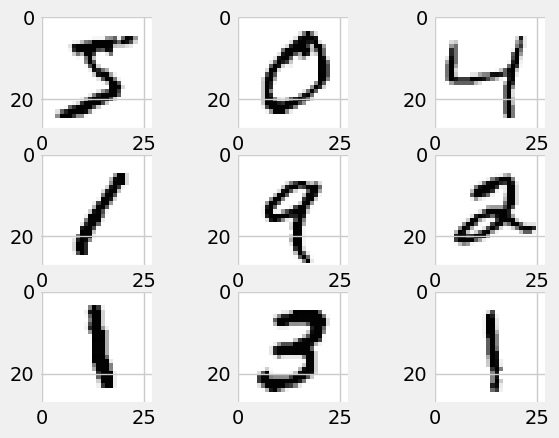

In [5]:
# Draw N first images

N = 9

for i in range(N):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_X[i], cmap=plt.get_cmap("Grays"))


In [6]:
# Normalize the data

def normalize(X):
    """
    Normalize the dataset to make mean = 0
    :param np.NDArray X: the dataset to normalize
    :return (np.array, np.array): 1) XBar, NDArray of normalized values;
        2) Mu, the original sample mean 
    """
    mu = X.mean(axis=0)
    XBar = X - mu
    return XBar, mu

/var/folders/4n/gsw99f6j6jq61zfxdwmknmxh0000gn/T/ipykernel_4656/2575607370.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


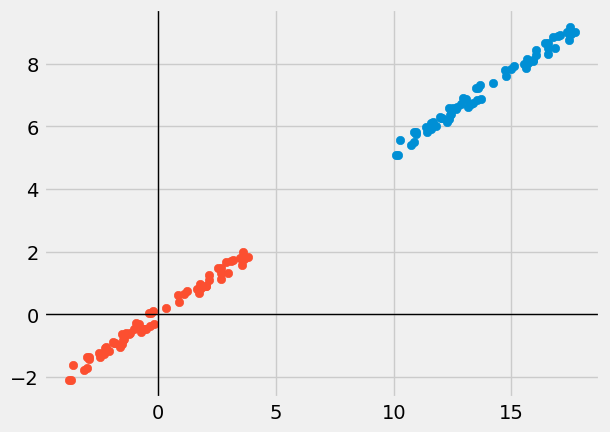

In [7]:
# Display the normalization result for a test data
random_X = np.random.random_sample((1, 64)) * 8 + 10
random_Y = np.random.random_sample((1, 64)) / 2 
random_X
random_XY = np.hstack((random_X.reshape((-1, 1)), random_Y.reshape((-1, 1))))
# Sheer  to 0.5
random_XY = random_XY @ np.array([[1, 0.5], [0, 1]])
random_XY
# random_XY = random_XY.T
norm_XY, norm_Mu = normalize(random_XY)


fig, ax = plt.subplots()
ax.scatter(random_XY[:,0], random_XY[:,1])
ax.scatter(norm_XY[:,0], norm_XY[:,1])
ax.axvline(linewidth=1, color="black")
ax.axhline(linewidth=1, color="black")
fig.show()

In [8]:
"""Test data normalization"""
from numpy.testing import assert_allclose


X0 = np.array([[0, 0.0], 
               [1.0, 1.0], 
               [2.0, 2.0]])
X0_normalize, X0_mean = normalize(X0)
# Test that normalized data has zero mean
assert_allclose(np.mean(X0_normalize, 0), np.zeros((2,)))
assert_allclose(X0_mean, np.array([1.0, 1.0]))
assert_allclose(normalize(X0_normalize)[0], X0_normalize)


X0 = np.array([[0, 0.0], 
               [1.0, 0.0], 
               [2.0, 0.0]])
X0_normalize, X0_mean = normalize(X0)
# Test that normalized data has zero mean and unit variance
assert_allclose(np.mean(X0_normalize, 0), np.zeros((2,)))
assert_allclose(X0_mean, np.array([1.0, 0.0]))
assert_allclose(normalize(X0_normalize)[0], X0_normalize)


In [25]:

def eig(S):
    """
    Find the eigencvalues and eigenvectors of the square matrix
    """
    eigvals, eigvecs = np.linalg.eig(S)
    sort_indices = np.argsort(eigvals)[::-1]
    return eigvals[sort_indices], eigvecs[:, sort_indices]

In [11]:
# Test eigen-values and -vectors from `eig`
def _flip_eigenvectors(B):
    """Flip the eigenvectors.    
    """
    signs = np.sign(B[np.argmax(np.abs(B), axis=0), range(B.shape[1])])
    return B * signs

def _normalize_eigenvectors(B):
    # Normalize eigenvectors to have unit length
    # Also flip the direction of the eigenvector based on
    # the first element
    B_normalized = B / np.linalg.norm(B, axis=0)
    for i in range(B.shape[1]):
        if (B_normalized[0, i] < 0):
            B_normalized[:, i] = -B_normalized[:, i]
    return B_normalized


A = np.array([[3, 2], [2, 3]])
expected_eigenvalues = np.array([5., 1.])
expected_eigenvectors = np.array(
    [[ 0.70710678, -0.70710678],
     [ 0.70710678,  0.70710678]]
)
actual_eigenvalues, actual_eigenvectors = eig(A)
# Check that the eigenvalues match
assert_allclose(actual_eigenvalues, expected_eigenvalues)
# Check that the eigenvectors match
assert_allclose(
    _normalize_eigenvectors(actual_eigenvectors),
    _normalize_eigenvectors(expected_eigenvectors),
)

# Compute projection matrix
Given an orthonormal basis spanned by the eigenvectors, compute the projection matrix. The projection matrix P can be computed as follows: $$P = \boldsymbol B(\boldsymbol B^T \boldsymbol B)^{-1} \boldsymbol B^T $$
is the array of basis vectors arranged as the columns of the matrix

In [12]:
def projection_matrix(B):
    """
    Compute the projection matix onto the space spanned by `B`
    Args:
        B: ndarray of dimensions
    Returns:
        P: projection matrix
    """
    return B @ np.linalg.inv(B.T @ B) @ B.T

In [13]:
B = np.array([[1, 0],
              [1, 1],
              [1, 2]])

assert_allclose(
    projection_matrix(B), 
    np.array([[5,  2, -1],
              [2,  2,  2],
              [-1, 2,  5]]) / 6
)

# Compute principal component analysis


Covariance matrix: $$S = \frac{\overline{\mathbf{X}}^T \overline{\mathbf{X}}}{n}$$ where $\overline{\mathbf{X}}$ is the normalized dataset and $n$ is the number of datapoints.

In [14]:
# Compute PCA

def PCA(X, num_components):
    """
    Compute the PCA results
    Args:
        X: ndarray of size (N, D), where D is the dimensionality of the data
            and N is the number of datapoints
        num_components: number of components to compute PCA upon
    Returns:
        reconstructed data; sample mean of X, principal values, principal components
    """

    X_normalized, mean = normalize(X)
    # Covariance matrix
    S = (X_normalized.T @ X_normalized) / X_normalized.shape[0]

    # Eigen{values, vectors} of the covariance matrix
    eig_vals, eig_vecs = eig(S)

    # Take the top components to analyze from the eigen{values,vectors}
    principal_vals, principal_components = eig_vals[:num_components], eig_vecs[:, :num_components]
    # Due to the precision error, the values can be complex
    #   therefore extract only the real part of the complex numbers
    principal_components = np.real(principal_components)

    # Reconstruct the data by projecting the normalized data onto the basis spanned by the principal components
    P = projection_matrix(principal_components)
    reconstruction_matrix = (P @ X_normalized.T).T + mean
    return reconstruction_matrix, mean, principal_vals, principal_components



In [15]:
X = np.array([[3, 6, 7],
              [8, 9, 0],
              [1, 5, 2]])

reconst, mean, principal_vals, principal_components = PCA(X, 1)

print("Cheacking mean...")
mean_exp = np.array([4, 20 / 3, 3])
np.testing.assert_allclose(mean, mean_exp, rtol=1e-5)
print("Mean is computed correctly!")

print("Checking principal values...")
principal_vals_exp = np.array([15.39677773])
np.testing.assert_allclose(principal_vals, principal_vals_exp, rtol=1e-5)
print("Principal Values are computed correctly!")

print("Checking principal components...")
principal_components_exp = np.array([[-0.68811066],
                                     [-0.40362611],
                                     [ 0.60298398]])
np.testing.assert_allclose(principal_components, principal_components_exp, rtol=1e-5)
print("Principal components are computed correctly!")

print("Checking reconstructed data...")
reconst_exp = np.array([[ 1.68166528,  5.30679755,  5.03153182],
                        [ 7.7868029 ,  8.8878974 , -0.31833472],
                        [ 2.53153182,  5.80530505,  4.2868029 ]])
np.testing.assert_allclose(reconst, reconst_exp, rtol=1e-5)
print("Reconstructed data is computed correctly!")

Cheacking mean...
Mean is computed correctly!
Checking principal values...
Principal Values are computed correctly!
Checking principal components...
Principal components are computed correctly!
Checking reconstructed data...
Reconstructed data is computed correctly!


In [16]:
random = np.random.RandomState(0)
X = random.randn(10, 5)

from sklearn.decomposition import PCA as SKPCA

for num_component in range(1, 4):
    # We can compute a standard solution given by scikit-learn's implementation of PCA
    pca = SKPCA(n_components=num_component, svd_solver="full")
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(X))
    reconst, _, _, _ = PCA(X, num_component)
    # The difference in the result should be very small (<10^-20)
    print(
        "difference in reconstruction for num_components = {}: {}".format(
            num_component, np.square(reconst - sklearn_reconst).sum()
        )
    )
    np.testing.assert_allclose(reconst, sklearn_reconst)

difference in reconstruction for num_components = 1: 1.1745823026229986e-28
difference in reconstruction for num_components = 2: 5.002081103530916e-28
difference in reconstruction for num_components = 3: 1.3907949018996873e-28


## PCA for MNIST digits

Once you have implemented PCA correctly, it's time to apply to the MNIST dataset. Each image in the dataset has a size of 28*28 pixels and thus has a dimensionality of 784. First, we will do some preprocessing of the data to get it into a good shape.

In [17]:
## Some preprocessing of the data
NUM_DATAPOINTS = 1000
X = (images.reshape(-1, 28 * 28)[:NUM_DATAPOINTS]) / 255.

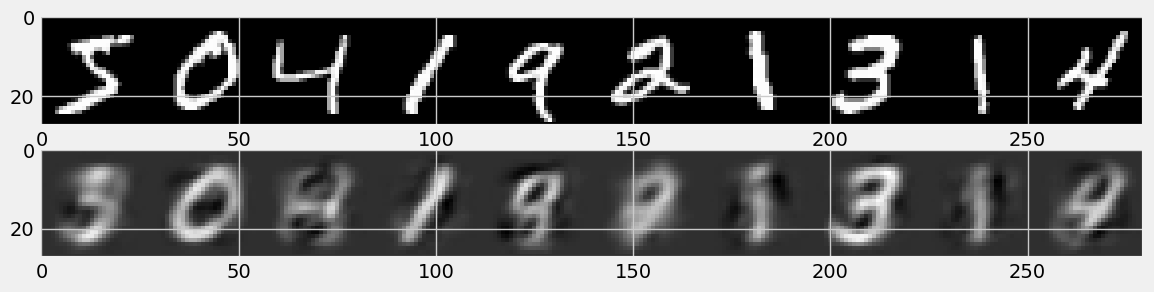

In [18]:
reconst, _, _, _ = PCA(X, num_components=10)
num_images_to_show = 10
reconst_images = np.reshape(reconst[:num_images_to_show], (-1, 28, 28))
fig, ax = plt.subplots(2, 1, figsize=(num_images_to_show * 3, 3))
ax[0].imshow(np.concatenate(np.reshape(X[:num_images_to_show], (-1, 28, 28)), -1), cmap="gray")
ax[1].imshow(np.concatenate(reconst_images, -1), cmap="gray")

In [19]:
def mse(predict, actual):
    """Helper function for computing the mean squared error (MSE)"""
    return np.square(predict - actual).sum(axis=1).mean()

In [20]:
loss = []
reconstructions = []
# Iterate over different number of principal components, and compute the MSE
for num_component in range(1, 100, 5):
    reconst, _, _, _ = PCA(X, num_component)
    error = mse(reconst, X)
    reconstructions.append(reconst)
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
loss = np.asarray(loss)

In [21]:
import pandas as pd
# Create a table showing the number of principal components and MSE
pd.DataFrame(loss, columns=['no. of components', 'mse']).head()

,no. of components,mse
0,1.0,46.465431
1,6.0,31.284116
2,11.0,24.259506
3,16.0,19.831531
4,21.0,16.731753


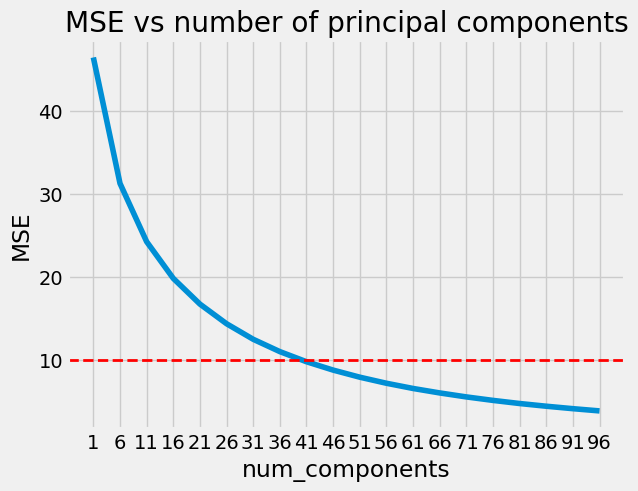

In [22]:
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(10, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(1, 100, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

In [23]:
@interact(image_idx=(0, 1000))
def show_num_components_reconst(image_idx):
    fig, ax = plt.subplots(figsize=(20., 20.))
    actual = X[image_idx]
    # concatenate the actual and reconstructed images as large image before plotting it
    x = np.concatenate([actual[np.newaxis, :], reconstructions[:, image_idx]])
    ax.imshow(np.hstack(x.reshape(-1, 28, 28)[np.arange(10)]),
              cmap='gray');
    ax.axvline(28, color='orange', linewidth=2)

interactive(children=(IntSlider(value=500, description='image_idx', max=1000), Output()), _dom_classes=('widge…

In [24]:
@interact(i=(0, 10))
def show_pca_digits(i=1):
    """Show the i th digit and its reconstruction"""
    plt.figure(figsize=(4,4))
    actual_sample = X[i].reshape(28,28)
    reconst_sample = (reconst[i, :]).reshape(28, 28)
    plt.imshow(np.hstack([actual_sample, reconst_sample]), cmap='gray')
    plt.grid(False)
    plt.show()

interactive(children=(IntSlider(value=1, description='i', max=10), Output()), _dom_classes=('widget-interact',…